In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from matplotlib.pyplot import rcParams

import xarray as xr
import numpy as np
import scipy as sp

import time
import requests

import soundings as sd
import classification as cl

from siphon.simplewebservice.wyoming import WyomingUpperAir

import re


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
%load_ext autoreload
%autoreload 1
%aimport soundings
%aimport classification

In [18]:
obs_soundings = sd.read_wyoming_sounding_txt(
    loc='gove', year=2021,
    split_txt='94150 YDGV Gove Airport Observations at ')

No soundings at 2021-01-06 0.
No soundings at 2021-01-09 0.
No soundings at 2021-01-10 0.
No soundings at 2021-01-13 0.
No soundings at 2021-01-17 0.
No soundings at 2021-01-20 0.
No soundings at 2021-01-23 0.
No soundings at 2021-01-30 0.
No soundings at 2021-01-31 0.
No soundings at 2021-02-03 0.
No soundings at 2021-02-04 0.
No soundings at 2021-02-10 0.
No soundings at 2021-02-13 0.
No soundings at 2021-02-14 0.
No soundings at 2021-02-17 0.
No soundings at 2021-02-20 0.
No soundings at 2021-02-21 0.
No soundings at 2021-02-24 0.
No soundings at 2021-02-27 0.
No soundings at 2021-02-28 0.


In [49]:
radar = '63'

obs_soundings = sd.read_wyoming_sounding_txt()
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings_{}.nc'.format(radar))
ACCESS_C_soundings = xr.open_dataset('ACCESS_C_soundings_{}.nc'.format(radar))
ERA5_soundings = xr.open_dataset('ERA5_soundings_{}.nc'.format(radar))
ERA5_soundings['p'].values = ERA5_soundings['p'].values*1e2

times_1 = set(ACCESS_G_soundings['time'].values)
times_2 = set(ACCESS_C_soundings['time'].values)
times_3 = set(ERA5_soundings['time'].values)
times_4 = set(obs_soundings['time'].values)
common_times = sorted(list(
    times_1.intersection(times_2).intersection(times_3).intersection(times_4)))

hours = [0]
days = 'all'

No soundings at 2021-02-26 12.
No soundings at 2021-02-27 12.


In [50]:
soundings_list = [
    obs_soundings, ACCESS_G_soundings, 
    ACCESS_C_soundings, ERA5_soundings]
new_soundings_list = []

for soundings in soundings_list:

    if radar == '42':
        soundings = soundings.sel(altitude=np.arange(200, 20100, 100))
    soundings = soundings.sel(time=common_times)
    soundings = soundings.where(
        soundings['pope_regime'] == 2).dropna(dim='time')
    if days != 'all':
        soundings = soundings.sel(time=days)
    soundings = soundings.sel(hour=hours)
    soundings = soundings.mean(dim=['hour', 'time'], skipna=True)
    new_soundings_list.append(soundings)

[
    obs_soundings, ACCESS_G_soundings, 
    ACCESS_C_soundings, ERA5_soundings] = new_soundings_list

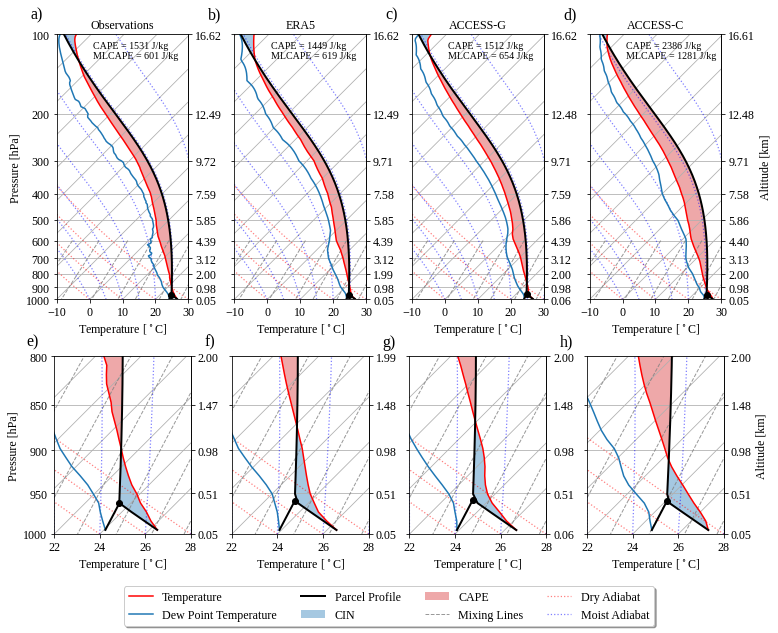

In [51]:
figsize = (12, 10)
fig = plt.figure(figsize=figsize)
# xlim = (20, 30)
# ylim = (1000, 800)
# xlim = (0, 30)
# ylim = (1000, 200)
xlim = (-10, 30)
ylim = (1000, 100)
ax1 = sd.plot_skewt(
    obs_soundings, fig=fig, subplots=(2, 4, 1), legend=False,
    right_ticks=False, title='Observations',
    xlim=xlim, ylim=ylim, right_tick_label=False)
ax2 = sd.plot_skewt(
    ERA5_soundings, fig=fig, subplots=(2, 4, 2), legend=False, 
    left_ticks=False, right_ticks=True, 
    title='ERA5', right_tick_label=False,
    xlim=xlim, ylim=ylim)
ax3 = sd.plot_skewt(
    ACCESS_G_soundings, fig=fig, subplots=(2, 4, 3), legend=False,
    left_ticks=False, right_ticks=True, title='ACCESS-G',
    xlim=xlim, ylim=ylim, right_tick_label=False)
ax4 = sd.plot_skewt(
    ACCESS_C_soundings, fig=fig, subplots=(2, 4, 4), legend=False,
    left_ticks=False, title='ACCESS-C',
    xlim=xlim, ylim=ylim)

xlim = (22, 28)
ylim = (1000, 800)

ax5 = sd.plot_skewt(
    obs_soundings, fig=fig, subplots=(2, 4, 5), legend=False,
    right_ticks=False, label_CAPE=False, right_tick_label=False,
    xlim=xlim, ylim=ylim, custom_ticks=True)
ax6 = sd.plot_skewt(
    ERA5_soundings, fig=fig, subplots=(2, 4, 6), legend=False, 
    left_ticks=False, right_ticks=True, label_CAPE=False,
    xlim=xlim, ylim=ylim, right_tick_label=False, custom_ticks=True)
ax7 = sd.plot_skewt(
    ACCESS_G_soundings, fig=fig, subplots=(2, 4, 7), legend=False,
    left_ticks=False, right_ticks=True,
    xlim=xlim, ylim=ylim, label_CAPE=False, right_tick_label=False,
    custom_ticks=True)
ax8 = sd.plot_skewt(
    ACCESS_C_soundings, fig=fig, subplots=(2, 4, 8), legend=False,
    left_ticks=False, label_CAPE=False, custom_ticks=True,
    xlim=xlim, ylim=ylim)
plt.subplots_adjust(wspace=.3)
plt.subplots_adjust(hspace=.05)

axes = [
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

cl.make_subplot_labels(axes, x_shift=-.2, y_shift=.06)

ax5.legend(
    loc='lower center', bbox_to_anchor=(2.45, -.55),
    ncol=4, fancybox=True, shadow=True)

plt.savefig(
    'darwin_sounding.png',
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [52]:
radar = '63'

obs_soundings = sd.read_wyoming_sounding_txt()
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings_{}.nc'.format(radar))
ACCESS_C_soundings = xr.open_dataset('ACCESS_C_soundings_{}.nc'.format(radar))
ERA5_soundings = xr.open_dataset('ERA5_soundings_{}.nc'.format(radar))
ERA5_soundings['p'].values = ERA5_soundings['p'].values*1e2

times_1 = set(ACCESS_G_soundings['time'].values)
times_2 = set(ACCESS_C_soundings['time'].values)
times_3 = set(ERA5_soundings['time'].values)
times_4 = set(obs_soundings['time'].values)
common_times = sorted(list(
    times_1.intersection(times_2).intersection(times_3).intersection(times_4)))

hours = [0]
days = 'all'

soundings_list = [
    obs_soundings, ACCESS_G_soundings, 
    ACCESS_C_soundings, ERA5_soundings]
mean_soundings_list = []
var_soundings_list = []

for soundings in soundings_list:

#     soundings = soundings[['u', 'v', 'pope_regime']]
    if radar == '42':
        soundings = soundings.sel(
            altitude=np.arange(200, 20100, 100))
    soundings = soundings.sel(time=common_times)
    soundings = soundings.where(
        soundings['pope_regime'] == 2).dropna(dim='time')
    if days != 'all':
        soundings = soundings.sel(time=days)
    soundings = soundings.sel(hour=hours)
    mean_soundings = soundings.mean(dim=['hour', 'time'], skipna=True)
    var_soundings = soundings.var(dim=['hour', 'time'], skipna=True)
    mean_soundings_list.append(mean_soundings)
    var_soundings_list.append(var_soundings)

[
    mean_obs_soundings, mean_ACCESS_G_soundings, 
    mean_ACCESS_C_soundings, mean_ERA5_soundings] = mean_soundings_list
[
    var_obs_soundings, var_ACCESS_G_soundings, 
    var_ACCESS_C_soundings, var_ERA5_soundings] = var_soundings_list

No soundings at 2021-02-26 12.
No soundings at 2021-02-27 12.


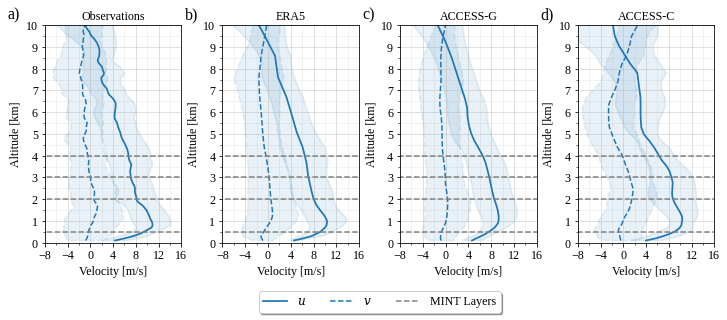

In [55]:
figsize = (12, 4)
fig, axes = plt.subplots(1, 4, figsize=figsize)

xlim = (-8, 16)
ylim = (0, 10e3)

sd.plot_wind_profile(
    mean_obs_soundings, var_obs_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[0], title='Observations')
sd.plot_wind_profile(mean_ERA5_soundings, var_ERA5_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[1], title='ERA5')
sd.plot_wind_profile(mean_ACCESS_G_soundings, var_ACCESS_G_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[2], title='ACCESS-G')
sd.plot_wind_profile(mean_ACCESS_C_soundings, var_ACCESS_C_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[3], title='ACCESS-C')

plt.subplots_adjust(wspace=.3)

cl.make_subplot_labels(axes, x_shift=-.275, y_shift=.03)

axes[0].legend(
    loc='lower center', bbox_to_anchor=(2.45, -0.35),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    'darwin_winds.png',
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [47]:
radar = 'gove'

obs_soundings = sd.read_wyoming_sounding_txt(
    loc='gove', year=2021,
    split_txt='94150 YDGV Gove Airport Observations at ')
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings_{}.nc'.format(radar))
ACCESS_C_soundings = xr.open_dataset('ACCESS_C_soundings_{}.nc'.format(radar))
ERA5_soundings = xr.open_dataset('ERA5_soundings_{}.nc'.format(radar))
ERA5_soundings['p'].values = ERA5_soundings['p'].values*1e2

times_1 = set(ACCESS_G_soundings['time'].values)
times_2 = set(ACCESS_C_soundings['time'].values)
times_3 = set(ERA5_soundings['time'].values)
times_4 = set(obs_soundings['time'].values)
common_times = sorted(list(
    times_1.intersection(times_2).intersection(times_3).intersection(times_4)))

hours = [0]
days = 'all'

soundings_list = [
    obs_soundings, ACCESS_G_soundings, 
    ACCESS_C_soundings, ERA5_soundings]
mean_soundings_list = []
var_soundings_list = []

for soundings in soundings_list:

#     soundings = soundings[['u', 'v', 'pope_regime']]
    if radar == '42':
        soundings = soundings.sel(
            altitude=np.arange(200, 20100, 100))
    soundings = soundings.sel(time=common_times)
    soundings = soundings.where(
        soundings['pope_regime'] == 2).dropna(dim='time')
    if days != 'all':
        soundings = soundings.sel(time=days)
    soundings = soundings.sel(hour=hours)
    mean_soundings = soundings.mean(dim=['hour', 'time'], skipna=True)
    var_soundings = soundings.var(dim=['hour', 'time'], skipna=True)
    mean_soundings_list.append(mean_soundings)
    var_soundings_list.append(var_soundings)

[
    mean_obs_soundings, mean_ACCESS_G_soundings, 
    mean_ACCESS_C_soundings, mean_ERA5_soundings] = mean_soundings_list
[
    var_obs_soundings, var_ACCESS_G_soundings, 
    var_ACCESS_C_soundings, var_ERA5_soundings] = var_soundings_list

No soundings at 2021-01-06 0.
No soundings at 2021-01-09 0.
No soundings at 2021-01-10 0.
No soundings at 2021-01-13 0.
No soundings at 2021-01-17 0.
No soundings at 2021-01-20 0.
No soundings at 2021-01-23 0.
No soundings at 2021-01-30 0.
No soundings at 2021-01-31 0.
No soundings at 2021-02-03 0.
No soundings at 2021-02-04 0.
No soundings at 2021-02-10 0.
No soundings at 2021-02-13 0.
No soundings at 2021-02-14 0.
No soundings at 2021-02-17 0.
No soundings at 2021-02-20 0.
No soundings at 2021-02-21 0.
No soundings at 2021-02-24 0.
No soundings at 2021-02-27 0.
No soundings at 2021-02-28 0.


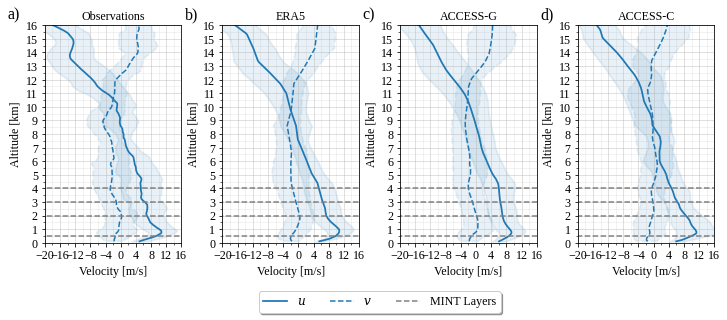

In [48]:
figsize = (12, 4)
fig, axes = plt.subplots(1, 4, figsize=figsize)

xlim = (-20, 16)
ylim = (0, 16e3)

sd.plot_wind_profile(
    mean_obs_soundings, var_obs_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[0], title='Observations')
sd.plot_wind_profile(mean_ERA5_soundings, var_ERA5_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[1], title='ERA5')
sd.plot_wind_profile(mean_ACCESS_G_soundings, var_ACCESS_G_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[2], title='ACCESS-G')
sd.plot_wind_profile(mean_ACCESS_C_soundings, var_ACCESS_C_soundings, legend=False, 
    xlim=xlim, ylim=ylim, fig=fig, ax=axes[3], title='ACCESS-C')

plt.subplots_adjust(wspace=.3)

cl.make_subplot_labels(axes, x_shift=-.275, y_shift=.03)

axes[0].legend(
    loc='lower center', bbox_to_anchor=(2.45, -0.35),
    ncol=3, fancybox=True, shadow=True)

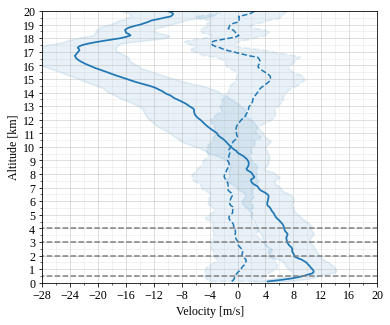

In [657]:
xlim = (-28, 20)
ylim = (0, 20e3)

sd.plot_wind_profile(
    mean_obs_soundings, var_obs_soundings, legend=False, 
    xlim=xlim, ylim=ylim)

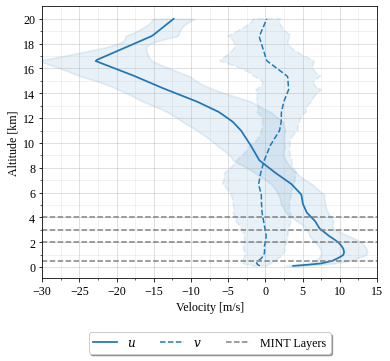

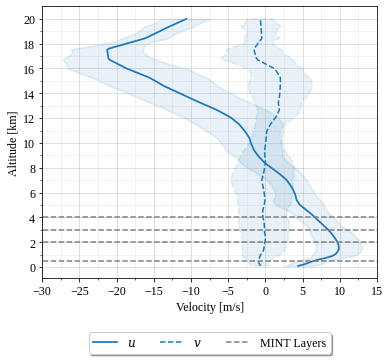

In [631]:
sd.plot_wind_profile(mean_ACCESS_G_soundings, var_ACCESS_G_soundings, legend=True)

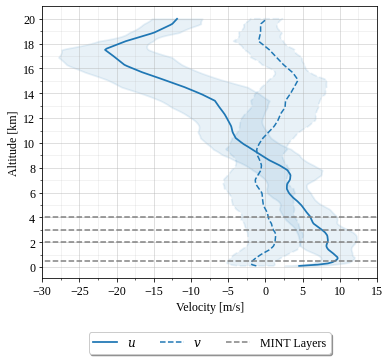

In [632]:
sd.plot_wind_profile(mean_ACCESS_C_soundings, var_ACCESS_C_soundings, legend=True)